# Predicting Relationship Quality from Relationship Attributes in 2022

## Summary 

In this project, we used a dataset on based on survey responses to common relationship questions to develop a logistic regression model to classify relationships into one of five relationship quality statuses: excellent, good, fair, poor, or very poor. The model developed below uses common relationship-based features such as whether the subject is married or not and how many children the subject hsa in the relationship.


## Introduction 

Relationship quality classification is an important topic for couples to be aware of, particularly when trying to maximize the amount of satisfaction each partner recieves from the relationship. Accurate relationship quality classification allows couples in relationships to assess the quality of their relationship to develop better targeted strategies to improve or maintain that relationship quality. It is often difficult for couples to estimate the perceived quality of their relationship, so we investigate below if our machine learning model can correctly classify the quality of a relationshup, based on common relationship attributes. The below analysis tries to answer: How well do relationship characteristics such as age, income category, marital status, relationship duration, and number of children predict relationship quality?

The dataset contains 1328 survey responses of common relationship characteristics such as the income category of the respondent and their estimated relationship quality (our target to predict). This dataset is from the Diverse Data Hub, created by Dr. Katie Burak & Dr. Elham E. Khoda: https://diverse-data-hub.github.io/website_files/description_pages/hcmst.html#download, and is originally based on Michael J. Rosenfeld, Reuben J. Thomas, and Sonia Hausen's survey: How Couples Meet and Stay Together 2017 (HCMST 2017) from https://data.stanford.edu/hcmst2017.

In our analysis below, we investigate whether a logistic regression model can correctly classify relationship attributes into one of five relationship quality statuses: excellent, good, fair, poor, or very poor.

### Library Imports

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import make_column_transformer
import os
from pathlib import Path
import pandera.pandas as pa
from pandera import DataFrameSchema, Column

### Load and Save Data

We start by reading in the data using a pandas dataframe from the diversedata CRAN package directly through the raw CSV URL: `https://cran.r-project.org/incoming/UL/diversedata/data-clean/hcmst.csv`. We then download a copy of the dataset to the `data` directory.

In [21]:
url = "https://cran.r-project.org/incoming/UL/diversedata/data-clean/hcmst.csv"
raw_hcmst = pd.read_csv(url)

# create data directory if it does not exist 
os.makedirs("data/raw/", exist_ok = True)

output_path = "data/raw/hcmst.csv"

raw_hcmst.to_csv(output_path, index = False)

### Data Validation

#### Data Validation 1: Correct data file format

In [24]:
# check file exists
p = Path("data/raw/hcmst.csv")
if not p.exists():
    raise FileNotFoundError(f"data file not found at {p.resolve()}")

# check correct extension
if p.suffix.lower() != ".csv":
    raise ValueError(f"expected '.csv' extension, got {p.suffix}")

# read file
hcmst = pd.read_csv(p)

# use pandera to validate that this object is a dataframe
file_schema = DataFrameSchema({})
hcmst = file_schema.validate(hcmst)

#### Data Validation 2: Correct column names

In [31]:
expected_columns = [
    "subject_age",
    "subject_education",
    "subject_sex",
    "subject_ethnicity",
    "subject_income_category",
    "subject_employment_status",
    "same_sex_couple",
    "married",
    "sex_frequency",
    "flirts_with_partner",
    "fights_with_partner",
    "relationship_duration",
    "children",
    "rel_change_during_pandemic",
    "inc_change_during_pandemic",
    "subject_had_covid",
    "partner_had_covid",
    "subject_vaccinated",
    "partner_vaccinated",
    "agree_covid_approach",
    "relationship_quality",
]

actual_columns = list(hcmst.columns)
if actual_columns != expected_columns:
    raise ValueError(
        f"unexpected columns.\nexpected:\n{expected_columns}\n\nfound:\n{actual_columns}"
    )
column_schema = DataFrameSchema(
    {
        name: Column(nullable=True)  # missingness is checked later
        for name in expected_columns
    },
    strict=True  # fail if there are extra columns
)

hcmst = column_schema.validate(hcmst)

#### Data Validation 3: Correct data file format

In [32]:
no_empty_rows_schema = DataFrameSchema(
    {},  # column rules checked earlier
    checks=[
        pa.Check(
            lambda df: ~(df.isna().all(axis=1)).any(),
            error="found at least one completely empty row in hcmst"
        )
    ]
)

hcmst = no_empty_rows_schema.validate(hcmst)

#### Data Validation 4: Missingness not beyond expected threshold

**Note**: The missingness validation in the next cell is applied **only to the columns used in the model** (`subject_age`, `subject_income_category`, `married`, `relationship_duration`, `children`, `relationship_quality`). 

In [35]:
missing_threshold = 0.05

cols_to_check_missing = [
    "subject_age",
    "subject_income_category",
    "married",
    "relationship_duration",
    "children",
    "relationship_quality",
]

missingness_schema = DataFrameSchema(
    {
        col: Column(
            nullable=True,
            checks=pa.Check(
                lambda s: s.isna().mean() <= missing_threshold,
                element_wise=False,
                error=(
                    f"column '{col}' has more than "
                    f"{missing_threshold:.0%} missing values"
                ),
            ),
        )
        for col in cols_to_check_missing
    }
)

hcmst = missingness_schema.validate(hcmst)

#### Data Validation 5: 

In [ ]:
#todo

#### Data Validation 6: 

In [ ]:
#todo

#### Data Validation 7: 

In [ ]:
#todo

#### Data Validation 8: 

In [ ]:
#todo

#### Data Validation 9: 

In [ ]:
#todo

#### Data Validation 10: 

In [ ]:
#todo

#### Data Validation 11: 

In [ ]:
#todo

In [34]:
# todo make sure the any changes to the hcmst is saved to data/processed (to separate the raw and preprocessed files)

# create data directory if it does not exist 
os.makedirs("data/processed/", exist_ok = True)

### EDA

In [4]:
hcmst.head()

,subject_age,subject_education,subject_sex,subject_ethnicity,subject_income_category,subject_employment_status,same_sex_couple,married,sex_frequency,flirts_with_partner,...,relationship_duration,children,rel_change_during_pandemic,inc_change_during_pandemic,subject_had_covid,partner_had_covid,subject_vaccinated,partner_vaccinated,agree_covid_approach,relationship_quality
0,53.0,high_school_grad,female,white,35k_40k,working_paid_employee,no,not_married,once_or_twice_a_week,a_few_times_a_week,...,1.500000,2.0,better_than_before,no_change,no,yes,not_vaccinated,not_vaccinated,completely_agree,excellent
1,72.0,some_college,female,white,75k_85k,working_paid_employee,no,married,once_a_month_or_less,never,...,57.416668,1.0,no_change,worse,no,no,fully_vaccinated_and_booster,fully_vaccinated_and_booster,mostly_agree,good
2,43.0,associate_degree,male,white,75k_85k,working_paid_employee,no,married,once_or_twice_a_week,a_few_times_a_week,...,22.333334,5.0,no_change,worse,no,no,fully_vaccinated_and_booster,fully_vaccinated_and_booster,completely_agree,excellent
3,64.0,some_college,male,white,75k_85k,working_paid_employee,no,married,once_or_twice_a_week,1_to_3_times_a_month,...,28.250000,2.0,no_change,no_change,no,no,fully_vaccinated_and_booster,fully_vaccinated_and_booster,completely_agree,good
4,60.0,high_school_grad,female,black,75k_85k,working_paid_employee,no,married,once_or_twice_a_week,a_few_times_a_week,...,38.916668,3.0,better_than_before,no_change,no,no,not_vaccinated,partially_vaccinated,completely_agree,excellent


#### Distribution of the Relationship Quality categorical variable shows that the dataset contains imbalanced classes, with a very large number of respondents reporting excellent or good relationship quality and a much lower number of respondents reporting fair, poor, and very poor relationship quality.

Text(0.5, 1.0, 'Distribution of Relationship Quality')

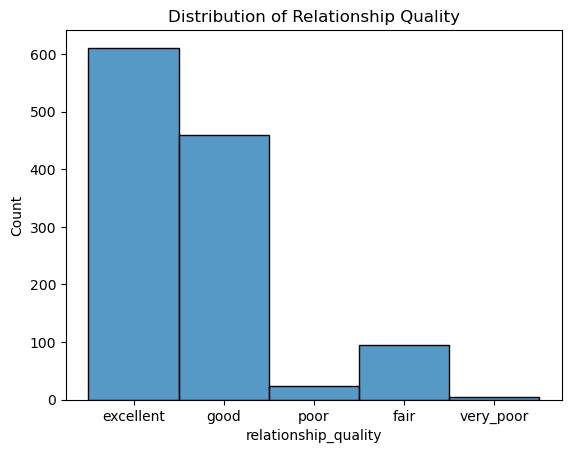

In [5]:
# plot distribution of relationship quality with relationship quality on x axis and count on y axis
sns.histplot(
    data = hcmst,
    x = 'relationship_quality', 
    stat = 'count'
).set_title('Distribution of Relationship Quality')


#### Our numeric predictor / input features show a high correlation between subject age and relationship duration with a $\rho$ value of 0.74, which means that as the subject's age increases, their relationship duration increases. Subject age and (numbed of) children show a weak negative correlation of -0.33, indicating that as subject age increases, the reported number of children slightly decreases.

Text(0.5, 1.0, 'Correlation Matrix of Relevant Predictor Variables')

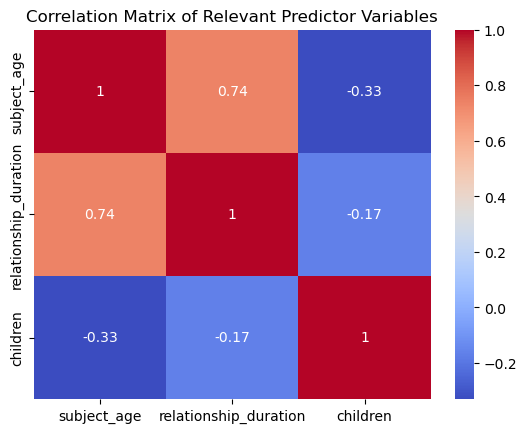

In [6]:
corr_mat = hcmst[['subject_age','relationship_duration', 'children']].corr()
sns.heatmap(corr_mat, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Relevant Predictor Variables')

#### The distribution of income categories show that we have a left skewed distribution, with most respondents making over 50k per year. For respondents who earn >= 50k / year, income distribution between 50k and 250k+ seems to be roughly uniformly distributed, showing that there is a pretty even spread of incomes between respondents as income passes 50k.

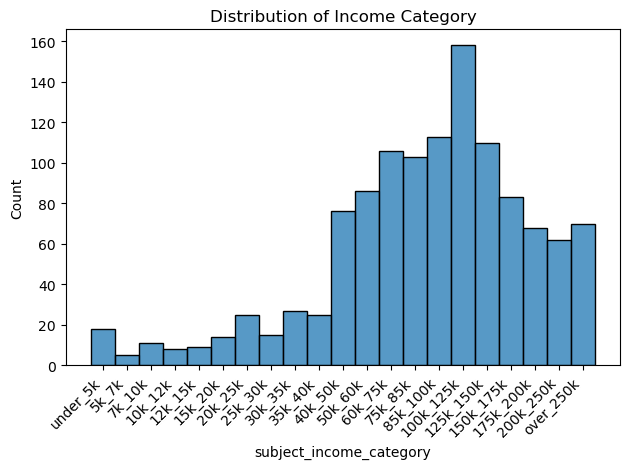

In [7]:
income_order = [
    'under_5k',
    '5k_7k',
    '7k_10k',
    '10k_12k',
    '12k_15k',
    '15k_20k',
    '20k_25k',
    '25k_30k',
    '30k_35k',
    '35k_40k',
    '40k_50k',
    '50k_60k',
    '60k_75k',
    '75k_85k',
    '85k_100k',
    '100k_125k',
    '125k_150k',
    '150k_175k',
    '175k_200k',
    '200k_250k',
    'over_250k'
]

hcmst['subject_income_category'] = pd.Categorical(hcmst['subject_income_category'], ordered = True, categories = income_order)

sns.histplot(
    data = hcmst,
    x = 'subject_income_category',
    bins = 23
).set_title('Distribution of Income Category')

plt.xticks(rotation = 45, ha = 'right')

plt.tight_layout()

#### We now split up the data into the relationship features that we want to predict relationship quality with. Input features include: Subject Age, Subject Income Category, Martial Status, Relationship Duration, and Number of Children, before splitting the data into train and test splits. We then conduct simple data cleaning through changing relevant numeric features such as age and number of children into integers, before reordering the income category feature to be ordered in ascending order by income.

In [8]:
# Clean Data
from sklearn.model_selection import train_test_split

X = hcmst[['subject_age', 'subject_income_category', 'married', 'relationship_duration', 'children']].copy()
y = hcmst['relationship_quality'].copy()

# split data into train and test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 123
)

# simple data cleaning - change subject age and children from floats to intgers 
X['subject_age'] = X['subject_age'].astype(int)
X['children'] = X['children'].astype(int)

# reorder income category 
X['subject_income_category'] = X['subject_income_category'].astype('category')
X['subject_income_category'] = X['subject_income_category'].cat.reorder_categories(
    ['under_5k', '5k_7k', '7k_10k', '10k_12k', '12k_15k', '15k_20k', '20k_25k', '25k_30k', '30k_35k', '35k_40k', '40k_50k', '50k_60k', '60k_75k', '75k_85k', '85k_100k', '100k_125k', '125k_150k', '150k_175k', '175k_200k', '200k_250k', 'over_250k'], ordered = True 
)

X['subject_income_category'].cat.categories.tolist()

['under_5k',
 '5k_7k',
 '7k_10k',
 '10k_12k',
 '12k_15k',
 '15k_20k',
 '20k_25k',
 '25k_30k',
 '30k_35k',
 '35k_40k',
 '40k_50k',
 '50k_60k',
 '60k_75k',
 '75k_85k',
 '85k_100k',
 '100k_125k',
 '125k_150k',
 '150k_175k',
 '175k_200k',
 '200k_250k',
 'over_250k']

#### Numeric features have different scales, with age having much larger values than relationship duration and number of children. Therefore, Standard Scaler is applied to numeric features so all numeric features contribute equally to the logistic regression model. Ordinal features such as subject income category are converted to ordinal categories, as their categories have an order based on the income of the subject. Categorical features such as marital status are one hot encoded, resulting in one column indicating martial status or not (0 / 1). Each transformation is wrapped in a column transformer.

In [9]:
# preprocess the data by applying the appropriate transformations to each
numeric_features = ['subject_age', 'relationship_duration', 'children']
ordinal_features = ['subject_income_category']
categorical_features = ['married']

# create a column transformer that applies transformations to each type of feature
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(drop='if_binary'), categorical_features),
    (OrdinalEncoder(), ordinal_features)
)

preprocessor

,transformers,"[('standardscaler', ...), ('onehotencoder', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


#### A scikit-learn pipeline is used to preprocess and train the model on the training data in one step. The pipeline first applies the preprocessor above to the training set to standardize numeric features and one hot encodes categorical features, before training the Logistic Regression model. The Logistic Regression model addresses our above issue regarding the class imbalance in relationship quality by giving the minority class a bigger penalty, so the model pays more attention to that observation

In [10]:
# fit model
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

logreg = make_pipeline(preprocessor, LogisticRegression(max_iter=1000, class_weight='balanced'))
logreg.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('standardscaler', ...), ('onehotencoder', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


#### To see how our model did on predicting relationship quality based on the training data, we plot a confusion matrix. We see that for respondents with excellent relationship quality, the model only correctly predicts 39% of relationships that have excellent relationship quality correctly (Recall = ~0.39). Of all relationships that are predicted to have excellent relationship quality,the model correctly predicts 55% of them (Precision = ~0.55).

#### For respondents with Good relationship quality, the model only correctly predicts 1.9% of them. For all relationships that are predicted to have good relationship quality, the model correctly predicts 54% of them. 

#### For respondents with Fair relationship quality, the model only correctly predicts 34% of them. Of all relationships that are predicted to have Fair relationship quality, the model correctly predicts 35% of them.

#### For respondents with Poor relationship quality, the model correctly predicts 23% of them. For all relationships that are predicted to have Poor relationship quality, the model only correctly predicts 2.3% of them. 

#### For respondents with Very Poor relationship quality, the model correctly predicts 67% of them (there are very few observations with very poor relationship quality so this prediction should be used carefully). Out of all relationships that are predicted to have very poor relationship quality, the model correctly predicts only 1.1% of them.

Text(0.5, 1.0, 'Confusion Matrix of Logistic Regression using training data')

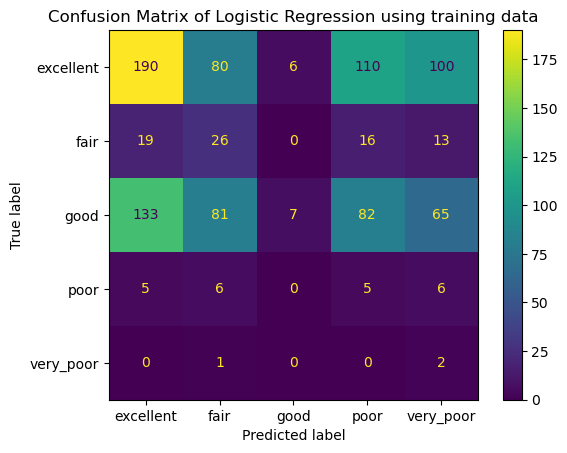

In [11]:
# training confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(logreg, X_train, y_train)
plt.grid(False)
plt.title('Confusion Matrix of Logistic Regression using training data')

#### To see how our model did on predicting relationship quality based on the testing set, we plot a confusion matrix for predictions on the test set. We see that for respondents with excellent relationship quality, the model only correctly predicts 45% of relationships that have excellent relationship quality correctly (Recall = ~0.45). Of all relationships that are predicted to have excellent relationship quality,the model correctly predicts 60% of them (Precision = ~0.595).

#### For respondents with Good relationship quality, the model only correctly predicts 2% of them. For all relationships that are predicted to have good relationship quality, the model correctly predicts 40% of them. 

#### For respondents with Fair relationship quality, the model only correctly predicts 35% of them. Of all relationships that are predicted to have Fair relationship quality, the model correctly predicts 14% of them.

#### For respondents with Poor relationship quality, the model correctly predicts 0% of them, as there is only 1 poor relationship quality observation in the test set. For all relationships that are predicted to have Poor relationship quality, the model only correctly predicts 0 of them, since the model predicted an observation to have Poor relationship quality 0 times.

#### For respondents with Very Poor relationship quality, the model correctly predicts 100% of them, but we must not take this result seriously because there is only one correct prediction with an observed relationship quality of very poor, and 0 observations where the model predicts any relationship quality other than very poor. Out of all relationships that are predicted to have very poor relationship quality, the model only correctly predicts 3% of them.

Text(0.5, 1.0, 'Confusion Matrix of Logistic Regression using testing data')

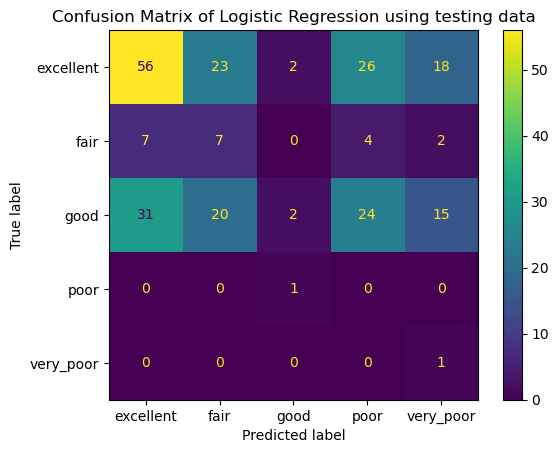

In [12]:
# testing confusion matrix
ConfusionMatrixDisplay.from_estimator(logreg, X_test, y_test)
plt.grid(False)
plt.title('Confusion Matrix of Logistic Regression using testing data')

In [13]:
# micro-average auc roc
from sklearn.metrics import roc_auc_score
y_score = logreg.predict_proba(X_test)
micro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="micro",
)

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.60


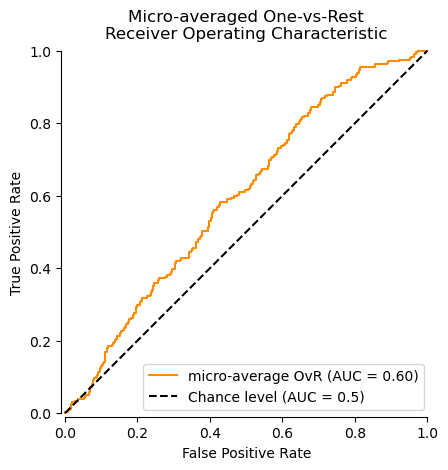

In [14]:
# micro-averaged auc roc plot
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

display = RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average OvR",
    curve_kwargs=dict(color="darkorange"),
    plot_chance_level=True,
    despine=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)

#### Our micro-averaged ROC curve above shows a AUC of 0.6. This means that our model is not the strongest at correctly predicting relationship quality based on the input relationship features we specified above. The ROC curve shows that our model is only slightly better than randomly guessing the relationship quality class, meaning that our model's accuracy is pretty weak.

## Discussion:

Our findings above indicate a overall accuracy of ~27.6% on the testing set, meaning that the model is poor at predicting the correct relationship quality based on features such as age, income_category, marital status, relationship duration, and number of children. We also see that the precision and recall of each relationship quality class is quite low in the training and testing set. Our poor accuracy, precision, and recall for all relationship quality classes tells us that with a Logistic Regression model, the features we included (age, income category, marital status, relationship duration, and number of children) do not predict relationship quality well.

This is generally what we expected to find because the features we chose are mostly external or demographic traits about the relationship that one can argue, do not define the emotional or personal status of a relationship. Since our features do not include deeper characteristics that could matter more for relationship quality compared to demographic features like age, it makes sense our Logistic Regression model is performing poorly.

These findings could change how people in relationships and researchers think about what defines relationship quality. Since our above results show that demographic or external features like age, number of children, income category, and relationship duration were not good predictors of relationship quality with our Logistic Regression model, people could place less focus on these relationship features when gauging the relationship quality of their own relationship. The results could lead to people in relationships placing more importance on emotional or behavioural metrics in relationships instead like how often partners openly communicate about problems. These emotional and behavioural relationship features could be much better predictors of relationship quality. These results could ultimately impact how relationship quality is assessed, by changing the focus to deeper personal relationship dynamics instead of surface level demographic features.

The future questions our above results could lead to are:

- What emotional or personal relationship features (that relate to both partners) best predict relationship quality?

- Could using a dataset that contains data for relationship matrics from both partners in the relationship improve accuracy of our above Logisitc Regression model?

- How much better (or worse) would non-linear models such as decision trees perform on the same above dataset?

- Which relationship features that we used above contribute most to predicting relationship quality? 

## References 

Diverse Data Hub. (n.d.). How Couples Meet and Stay Together. https://diverse-data-hub.github.io/website_files/description_pages/hcmst.html

R Core Team. (n.d.). hcmst.csv [Data set]. CRAN. https://cran.r-project.org/incoming/UL/diversedata/data-clean/hcmst.csv

Rosenfeld, M. J., Thomas, R. J., & Hausen, S. (2023). How Couples Meet and Stay Together 2017–2020–2022 combined dataset [Data set]. Stanford University Libraries. https://data.stanford.edu/hcmst2017

Timbers, T. A., Ostblom, J., D’Andrea, F., Lourenzutti, R., & Chen, D. (n.d.). 11 Conda lock: Reproducible lock files for conda environments. In Reproducible and trustworthy workflows for data science. UBC Master of Data Science. https://ubc-dsci.github.io/reproducible-and-trustworthy-workflows-for-data-science/lectures/090-conda-lock.html